In [266]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

import joblib

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500

## Config

In [267]:
class Config:
    target_col = 'pm2_5'
    n_splits = 4
    random_state = 42
    id_col = 'id'
    missing_threshold = 0.7
    top_features = 70
    clip_threshold = 0.97

    # Default hyperparameters
    cat_params = {
        'iterations': 1000,
        'learning_rate': 0.03,
        'depth': 6,
        'eval_metric': 'RMSE',
        'random_seed': random_state,
        'early_stopping_rounds': 250,
        'verbose': 100
    }
    lgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': -1,
        'random_state': random_state,
        'verbosity': -1
    }
    xgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.3,
        'max_depth': 6,
        'random_state': random_state,
        'objective': 'reg:squarederror'
    }
    lasso_params = {'alpha': 0.001, 'random_state': random_state}
    svr_params = {'C': 1.0, 'epsilon': 0.1}

## Load data

In [268]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [269]:
# Remove columns with too many missing values
train = train.loc[:, train.isnull().mean() < Config.missing_threshold]
test = test.loc[:, test.isnull().mean() < Config.missing_threshold]  

In [270]:
# Create GroupKFold
def create_folds(data):
    data['folds'] = -1
    gkf = GroupKFold(n_splits=Config.n_splits)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=data['city']), start=1):
        data.loc[val_idx, 'folds'] = fold
    return data

train = create_folds(train)

### Explore data

In [271]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,3
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,3
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741,3
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600,3
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731,3


In [272]:
# Calculate PM2.5 standard deviation per location
location_variance = train.groupby('city')[Config.target_col].std().reset_index()
location_variance.columns = ['city', 'pm2_5_std']
location_variance = location_variance.sort_values(by='pm2_5_std', ascending=False).reset_index(drop=True)
location_variance

,city,pm2_5_std
0,Lagos,52.843883
1,Nairobi,24.982218
2,Bujumbura,22.353384
3,Kampala,14.346829


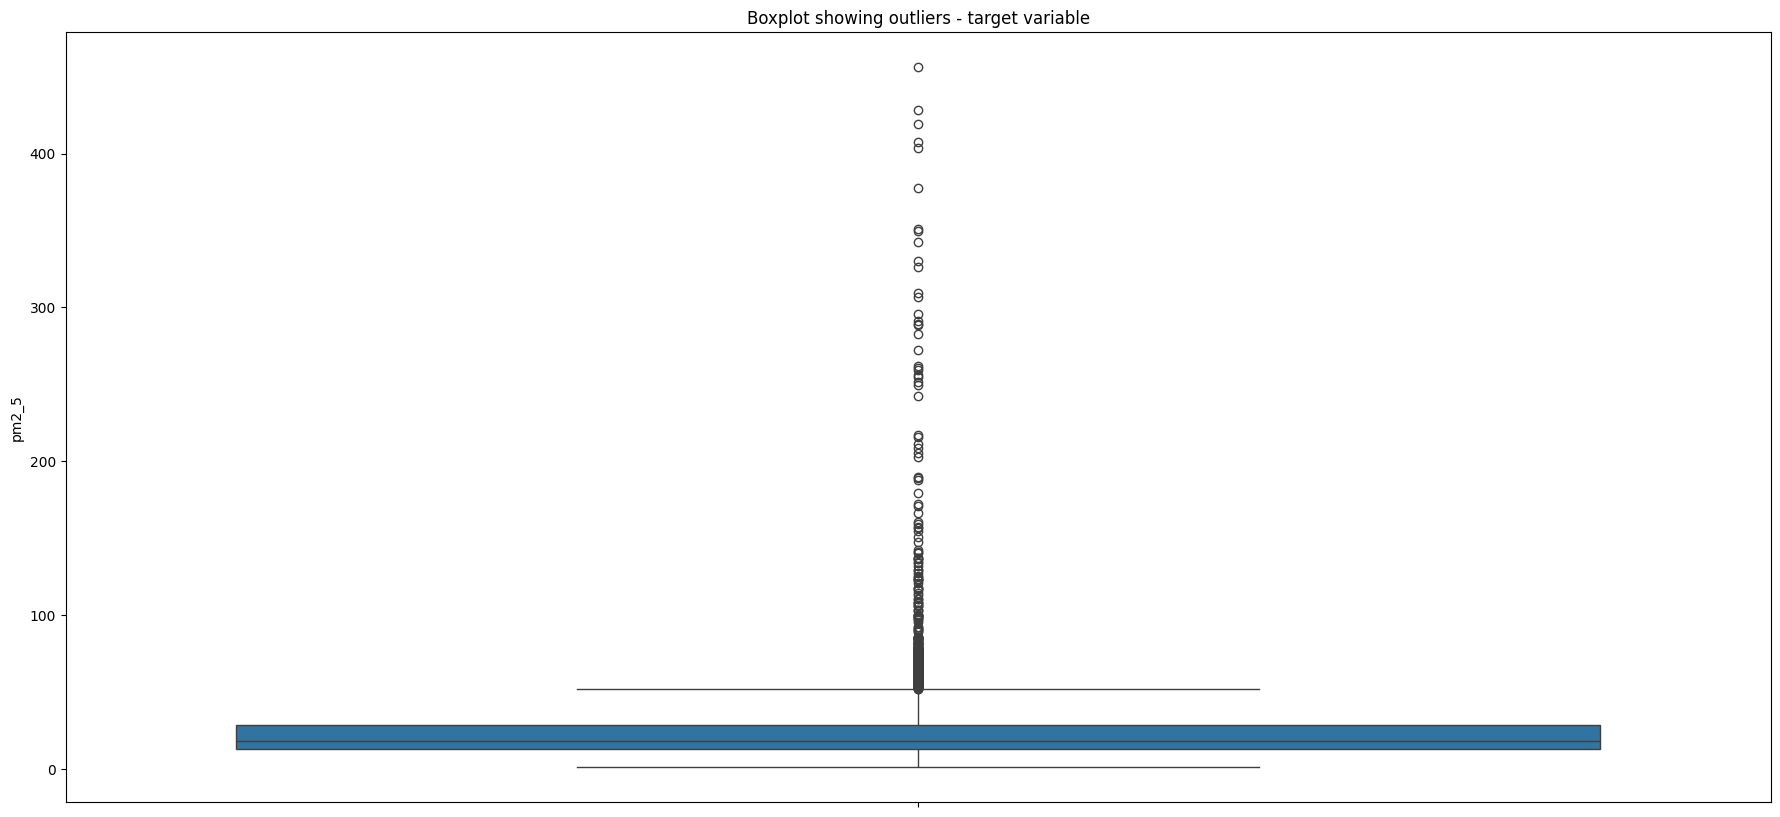

In [273]:
# Check for outliers in the target variable
plt.figure(figsize = (22, 10))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

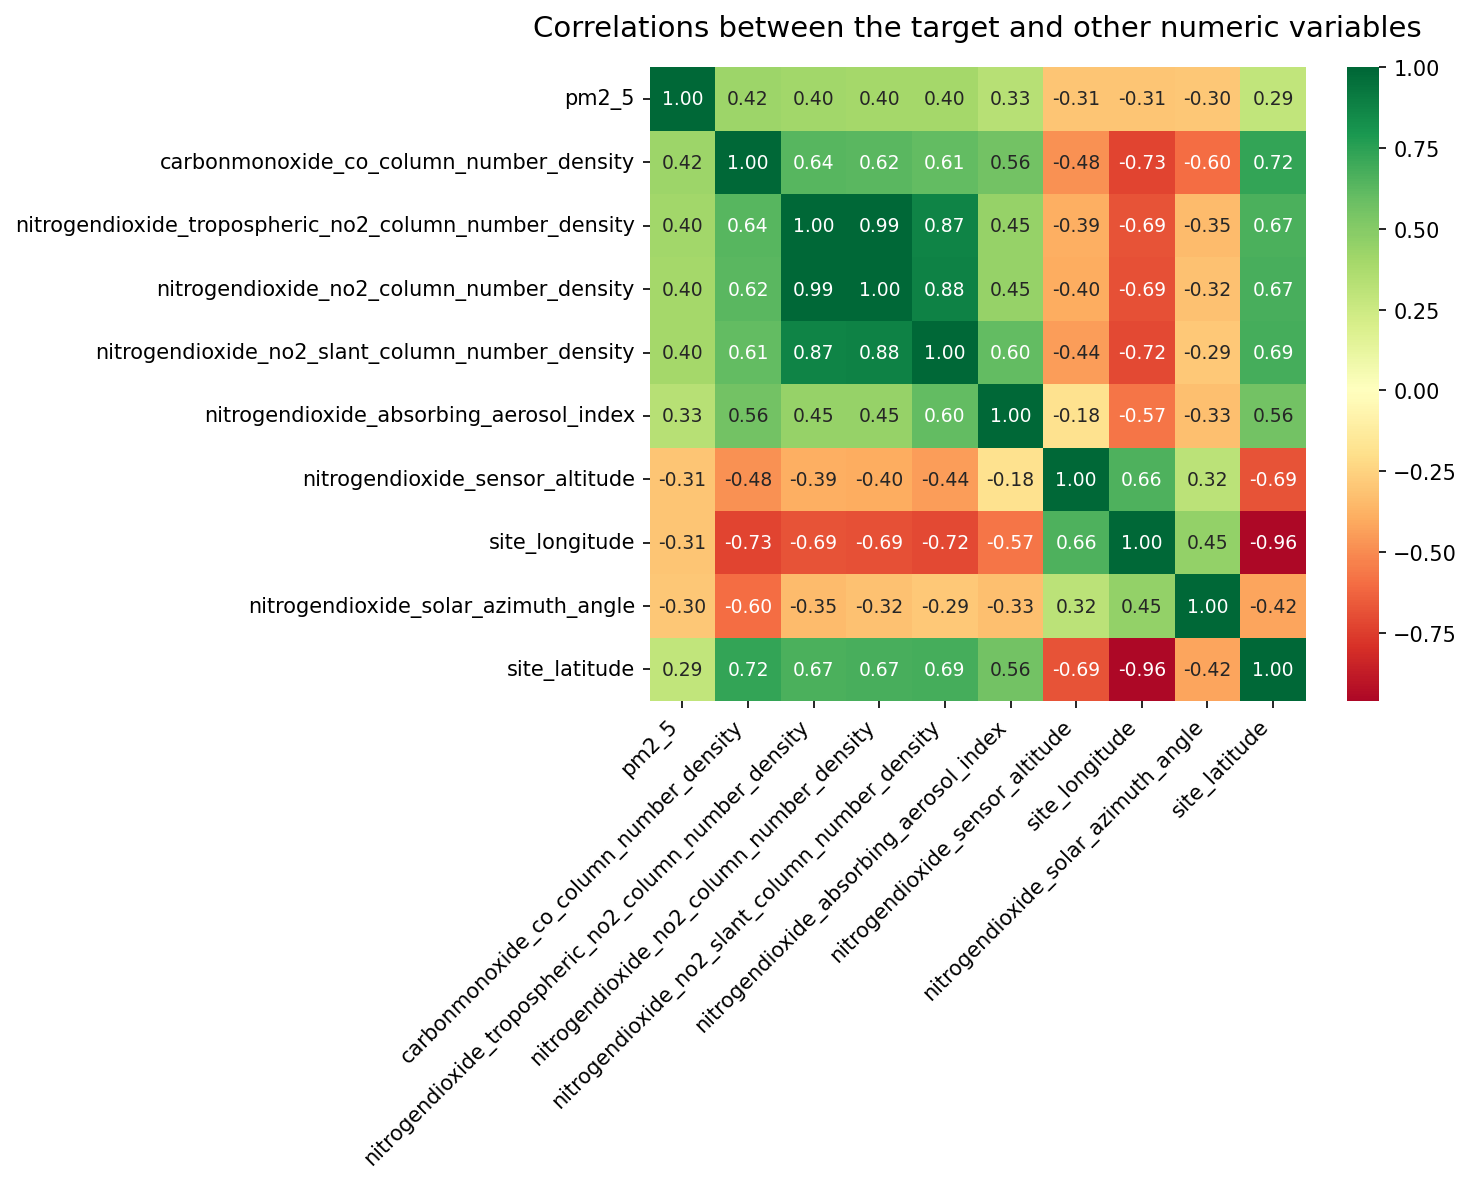

In [274]:
# Plot correlations between numerical features and target
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending=False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()

plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(
    corr, cmap='RdYlGn', annot=True, center=0, fmt=".2f", 
    annot_kws={"size": 9}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlations between the target and other numeric variables', pad=15, fontdict={'size': 14})
plt.tight_layout()
plt.show()

## Feature engineering

In [275]:
# Feature engineering
def feature_engineering(train, test):
    le = LabelEncoder()
    data = pd.concat([train, test])
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')
    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['date', 'id', 'city', 'country']]
    print(f'Categorical columns: {categorical_cols}')

    # Date features
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.isocalendar().week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['dayofweek'].isin([5,6]).astype(int)

    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()
    numerical_cols.remove(Config.target_col)
    numerical_cols.remove('folds')
    numerical_cols.remove('hour')
    numerical_cols.remove('site_latitude')
    numerical_cols.remove('site_longitude') 
    print(f'Numerical columns: {numerical_cols}')

    # Fill in missing values by forward and backward fill within each city and location
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum() > 0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        for col in nan_cols:
            data[col] = (
                data.groupby(["city", "location"])[col]
                    .transform(lambda x: x.ffill().bfill())
                    .fillna(data[col].median())  # global fallback
                )

    # Encode categorical features
    for col in categorical_cols + ['date']:
        data[col] = le.fit_transform(data[col])

    # Split back into train and test
    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    features = [col for col in data.columns if col not in 
                [Config.target_col, Config.id_col, 'folds', 'country', 'city', 'site_id', 'site_latitude', 'site_longitude']]
  
    return train, test, features

train, test, features = feature_engineering(train, test)

Categorical columns: ['site_id', 'location']
Numerical columns: ['date', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle', 'sulphurdioxide_sensor_zenith_angle', 'sulphurdioxide_solar_azimuth_angle', 'sulphurdioxide_solar_zenith_angle', 'sulphurdioxide_so2_column_number_density_15km', 'month', 'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude', 'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle', 'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'nitrogendioxide_tropopau

In [276]:
test


,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds,location,week,day,dayofweek,is_weekend
214,id_yorywxet0a,82,5.54551,-0.21771,Accra,Ghana,233,13,-0.000134,0.758259,...,26.927189,-86.776757,25.522445,NaN,NaN,80,36,6,2,0
215,id_9rhbkh8kye,82,5.54551,-0.21771,Accra,Ghana,234,13,0.000325,1.170923,...,26.927189,-86.776757,25.522445,NaN,NaN,80,36,7,3,0
216,id_oh2pg7ik9m,82,5.54551,-0.21771,Accra,Ghana,235,13,-0.000052,0.977610,...,26.927189,-86.776757,25.522445,NaN,NaN,80,36,8,4,0
217,id_u5xtrnbshq,82,5.54551,-0.21771,Accra,Ghana,236,12,-0.000052,0.977610,...,61.874710,-90.643272,11.872849,NaN,NaN,80,36,9,5,1
218,id_pfcdhqpggy,82,5.54551,-0.21771,Accra,Ghana,237,12,0.000412,0.622374,...,61.874710,-90.643272,11.872849,NaN,NaN,80,38,20,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,id_z2s38nz9hk,106,3.88712,11.53998,Yaoundé,Cameroon,324,11,0.000009,0.654652,...,65.605360,-153.417354,15.039202,NaN,NaN,78,8,24,5,1
2779,id_c9cycuvetl,107,3.89696,11.50603,Yaoundé,Cameroon,321,12,0.000009,0.654652,...,16.577282,-125.511751,25.086502,NaN,NaN,79,8,21,2,0
2780,id_8xu1ardxni,107,3.89696,11.50603,Yaoundé,Cameroon,322,12,0.000009,0.654652,...,16.577282,-125.511751,25.086502,NaN,NaN,79,8,22,3,0
2781,id_aumy97t1iu,107,3.89696,11.50603,Yaoundé,Cameroon,323,12,0.000009,0.654652,...,16.577282,-125.511751,25.086502,NaN,NaN,79,8,23,4,0


In [277]:
train.isna().sum()


id                                                          0
site_id                                                     0
site_latitude                                               0
site_longitude                                              0
city                                                        0
country                                                     0
date                                                        0
hour                                                        0
sulphurdioxide_so2_column_number_density                    0
sulphurdioxide_so2_column_number_density_amf                0
sulphurdioxide_so2_slant_column_number_density              0
sulphurdioxide_cloud_fraction                               0
sulphurdioxide_sensor_azimuth_angle                         0
sulphurdioxide_sensor_zenith_angle                          0
sulphurdioxide_solar_azimuth_angle                          0
sulphurdioxide_solar_zenith_angle                           0
sulphurd

## Feature selection

### Embedded method

In [278]:
# Initialize CatBoost Regressor
model = CatBoostRegressor(**Config.cat_params)

train_set  = train[train['folds'].isin([1.0, 3.0, 4.0])]
val_set = train[train['folds'].isin([2.0])]

# Train the model on the training data
model.fit(train_set[features], train_set[Config.target_col], eval_set=(val_set[features], val_set[Config.target_col]), verbose=100,  early_stopping_rounds=250)

# Get feature importance
feature_importances = model.get_feature_importance(prettified=True)

# Display the top features
print(feature_importances)

0:	learn: 24.3316165	test: 25.9211978	best: 25.9211978 (0)	total: 3.46ms	remaining: 3.46s
100:	learn: 15.2425152	test: 24.9430613	best: 24.9430613 (100)	total: 210ms	remaining: 1.87s
200:	learn: 13.0957832	test: 24.9123458	best: 24.9050712 (179)	total: 417ms	remaining: 1.66s
300:	learn: 11.6960749	test: 24.9409220	best: 24.9050712 (179)	total: 618ms	remaining: 1.44s
400:	learn: 10.2126487	test: 24.9609948	best: 24.9050712 (179)	total: 816ms	remaining: 1.22s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 24.90507116
bestIteration = 179

Shrink model to first 180 iterations.
                                           Feature Id  Importances
0                                            location    58.320591
1             carbonmonoxide_co_column_number_density     9.138872
2                                                date     3.545006
3                                ozone_cloud_fraction     1.921184
4   nitrogendioxide_tropospheric_no2_column_number...     1.76362

In [279]:
# Select top K features based on feature importance
top_features = feature_importances.head(Config.top_features)['Feature Id'].tolist()
print(f'Top {Config.top_features} features: {top_features}')


Top 70 features: ['location', 'carbonmonoxide_co_column_number_density', 'date', 'ozone_cloud_fraction', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'uvaerosolindex_solar_azimuth_angle', 'week', 'cloud_surface_albedo', 'sulphurdioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'month', 'ozone_o3_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_absorbing_aerosol_index', 'nitrogendioxide_sensor_altitude', 'cloud_cloud_top_height', 'cloud_solar_azimuth_angle', 'cloud_cloud_fraction', 'sulphurdioxide_cloud_fraction', 'formaldehyde_solar_azimuth_angle', 'nitrogendioxide_solar_azimuth_angle', 'carbonmonoxide_solar_azimuth_angle', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'uvaerosolindex_absorbing_aerosol_index', 'uvaerosolindex_sensor_altitude', 'formaldehyde_tropospheric_hcho_column_n

In [280]:
# Drop highly correlated features
def drop_highly_correlated_features(data, features, threshold=0.9):
    corr_matrix = data[features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f'Dropping {len(to_drop)} highly correlated features: {to_drop}')
    reduced_features = [feature for feature in features if feature not in to_drop]
    return reduced_features
reduced_features = drop_highly_correlated_features(train, top_features, threshold=0.9)

print(f'Reduced features: {reduced_features}')

Dropping 17 highly correlated features: ['sulphurdioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'month', 'nitrogendioxide_no2_column_number_density', 'cloud_solar_azimuth_angle', 'formaldehyde_solar_azimuth_angle', 'nitrogendioxide_solar_azimuth_angle', 'carbonmonoxide_solar_azimuth_angle', 'uvaerosolindex_sensor_azimuth_angle', 'cloud_cloud_top_pressure', 'uvaerosolindex_solar_zenith_angle', 'cloud_cloud_base_height', 'formaldehyde_hcho_slant_column_number_density', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_15km', 'cloud_cloud_base_pressure', 'ozone_o3_column_number_density_amf']
Reduced features: ['location', 'carbonmonoxide_co_column_number_density', 'date', 'ozone_cloud_fraction', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'uvaerosolindex_solar_azimuth_angle', 'week', 'cloud_surface_albedo', 'ozone_o3_column_number_density', 'sulphurdioxide_so2_column_number_den

## Cross Validation with GroupKFold

In [281]:
# Perform cross-validation with GroupKFold
oof_predictions = np.zeros(len(train))
test_predictions = np.zeros(len(test))
fold_rmse_list = []

for fold in range(1, Config.n_splits + 1):  
    print(f'Training fold {fold}...')
   
    train_set = train[train['folds'] != fold]
    val_set = train[train['folds'] == fold]

    # Clip the target of the training set to remove outliers
    train_set[Config.target_col] = np.where(train_set[Config.target_col] >= train_set[Config.target_col].quantile(Config.clip_threshold), train_set[Config.target_col].quantile(Config.clip_threshold), train_set[Config.target_col])

    model = CatBoostRegressor(**Config.cat_params)
    model.fit(train_set[reduced_features], train_set[Config.target_col], eval_set=(val_set[reduced_features], val_set[Config.target_col]))

    oof_predictions[val_set.index] = model.predict(val_set[reduced_features])
    test_predictions += model.predict(test[reduced_features]) / Config.n_splits

    fold_rmse = root_mean_squared_error(val_set[Config.target_col], oof_predictions[val_set.index])
    print(f'Fold {fold} RMSE: {fold_rmse}')
    fold_rmse_list.append(fold_rmse)

    print('-' * 112)

# Mean RMSE across all folds
mean_rmse = np.mean(fold_rmse_list)
print(f'Mean RMSE across all folds: {mean_rmse}')

Training fold 1...
0:	learn: 20.5224479	test: 14.5479823	best: 14.5479823 (0)	total: 2.18ms	remaining: 2.18s
100:	learn: 12.5475850	test: 13.1892932	best: 13.1664831 (89)	total: 146ms	remaining: 1.3s
200:	learn: 10.5917729	test: 13.1280761	best: 13.1239730 (193)	total: 285ms	remaining: 1.13s
300:	learn: 9.1660607	test: 13.1545207	best: 13.1156426 (273)	total: 426ms	remaining: 989ms
400:	learn: 7.9714999	test: 13.1861329	best: 13.1156426 (273)	total: 563ms	remaining: 841ms
500:	learn: 7.1236393	test: 13.2425698	best: 13.1156426 (273)	total: 702ms	remaining: 699ms
Stopped by overfitting detector  (250 iterations wait)

bestTest = 13.11564258
bestIteration = 273

Shrink model to first 274 iterations.
Fold 1 RMSE: 13.115642588822062
----------------------------------------------------------------------------------------------------------------
Training fold 2...
0:	learn: 14.9210998	test: 25.5510000	best: 25.5510000 (0)	total: 1.8ms	remaining: 1.8s
100:	learn: 10.1281171	test: 25.0366764	b

## Model ensemble

In [282]:
# Global variable to store best test predictions
best_test_pred = None
best_rmse = float("inf")  # track best score
best_models = None

def objective(trial):
    global best_test_pred, best_rmse, best_models

    # Suggest hyperparameters for each model
    cat_params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'early_stopping_rounds': 250,
        'random_seed': Config.random_state,
        'verbose': 0
    }
    lgb_params = {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('lgb_max_depth', 3, 12),
        'random_state': Config.random_state,
        'verbosity': -1
    }
    xgb_params = {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 12),
        'random_state': Config.random_state,
        'objective': 'reg:squarederror'
    }
    lasso_params = {'alpha': trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True), 'random_state': Config.random_state}
    svr_params = {
        'C': trial.suggest_float('svr_C', 0.1, 10.0, log=True),
        'epsilon': trial.suggest_float('svr_epsilon', 0.01, 1.0, log=True)
    }

    # Cross-validation
    oof_predictions = np.zeros(len(train))
    fold_rmse_list = []

    for fold in range(1, Config.n_splits + 1):
        train_set = train[train['folds'] != fold].copy()
        val_set = train[train['folds'] == fold].copy()

        # Clip target
        clip_val = train_set[Config.target_col].quantile(Config.clip_threshold)
        train_set[Config.target_col] = np.where(
            train_set[Config.target_col] >= clip_val, clip_val, train_set[Config.target_col]
        )

        # Define models (Lasso & SVR with imputer)
        models = {
            "cat": CatBoostRegressor(**cat_params),
            "lgb": LGBMRegressor(**lgb_params),
            "xgb": XGBRegressor(**xgb_params),
            "lasso": Lasso(**lasso_params),
            "svr": SVR(**svr_params)
        }

        val_preds = np.zeros((len(val_set), len(models)))
        test_preds = np.zeros((len(test), len(models)))

        # Train each model and predict
        for i, (name, model) in enumerate(models.items()):
            model.fit(train_set[reduced_features], train_set[Config.target_col])
            val_preds[:, i] = model.predict(val_set[reduced_features])
            test_preds[:, i] = model.predict(test[reduced_features])

        # Ensemble with equal weights
        oof_predictions[val_set.index] = np.mean(val_preds, axis=1)

        # Fold RMSE
        fold_rmse = root_mean_squared_error(val_set[Config.target_col], oof_predictions[val_set.index])
        fold_rmse_list.append(fold_rmse)
    
    mean_rmse = np.mean(fold_rmse_list)

    # Save best test prediction
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        # average test predictions across folds
        best_test_pred = np.mean(test_preds, axis=1)
        best_models = {name: model for name, model in models.items()}

    return mean_rmse

# Run Optuna study to optimize hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # adjust n_trials

print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-09-21 11:24:34,389] A new study created in memory with name: no-name-314533c9-e606-4964-8d39-d31ea93f5a8d
[I 2025-09-21 11:24:48,737] Trial 0 finished with value: 28.63100179795706 and parameters: {'cat_learning_rate': 0.014334267156216551, 'cat_depth': 5, 'lgb_learning_rate': 0.015394316672803953, 'lgb_max_depth': 8, 'xgb_learning_rate': 0.0659223048522342, 'xgb_max_depth': 4, 'lasso_alpha': 0.3218365264724017, 'svr_C': 1.8572522532317222, 'svr_epsilon': 0.01150243947530042}. Best is trial 0 with value: 28.63100179795706.
[I 2025-09-21 11:25:04,062] Trial 1 finished with value: 28.697695197055772 and parameters: {'cat_learning_rate': 0.034187891990176474, 'cat_depth': 5, 'lgb_learning_rate': 0.014160571206020866, 'lgb_max_depth': 6, 'xgb_learning_rate': 0.014798403971814797, 'xgb_max_depth': 7, 'lasso_alpha': 0.31882601400656707, 'svr_C': 8.957499341558416, 'svr_epsilon': 0.29866658241983146}. Best is trial 0 with value: 28.63100179795706.
[I 2025-09-21 11:25:34,222] Trial 2 f

Best hyperparameters: {'cat_learning_rate': 0.058619437791138145, 'cat_depth': 5, 'lgb_learning_rate': 0.07954627546219076, 'lgb_max_depth': 4, 'xgb_learning_rate': 0.07814554046619587, 'xgb_max_depth': 9, 'lasso_alpha': 0.00025748969545099146, 'svr_C': 0.17944985590146514, 'svr_epsilon': 0.03428442679905185}
Best RMSE: 27.876244380587003


In [283]:
# Save best models
folder_name = f"./weights/{best_rmse:.2f}"  # keep 4 decimal places
os.makedirs(folder_name, exist_ok=True)

# Save models
for name, model in best_models.items():
    joblib.dump(model, f"{folder_name}/best_model_{name}.pkl")

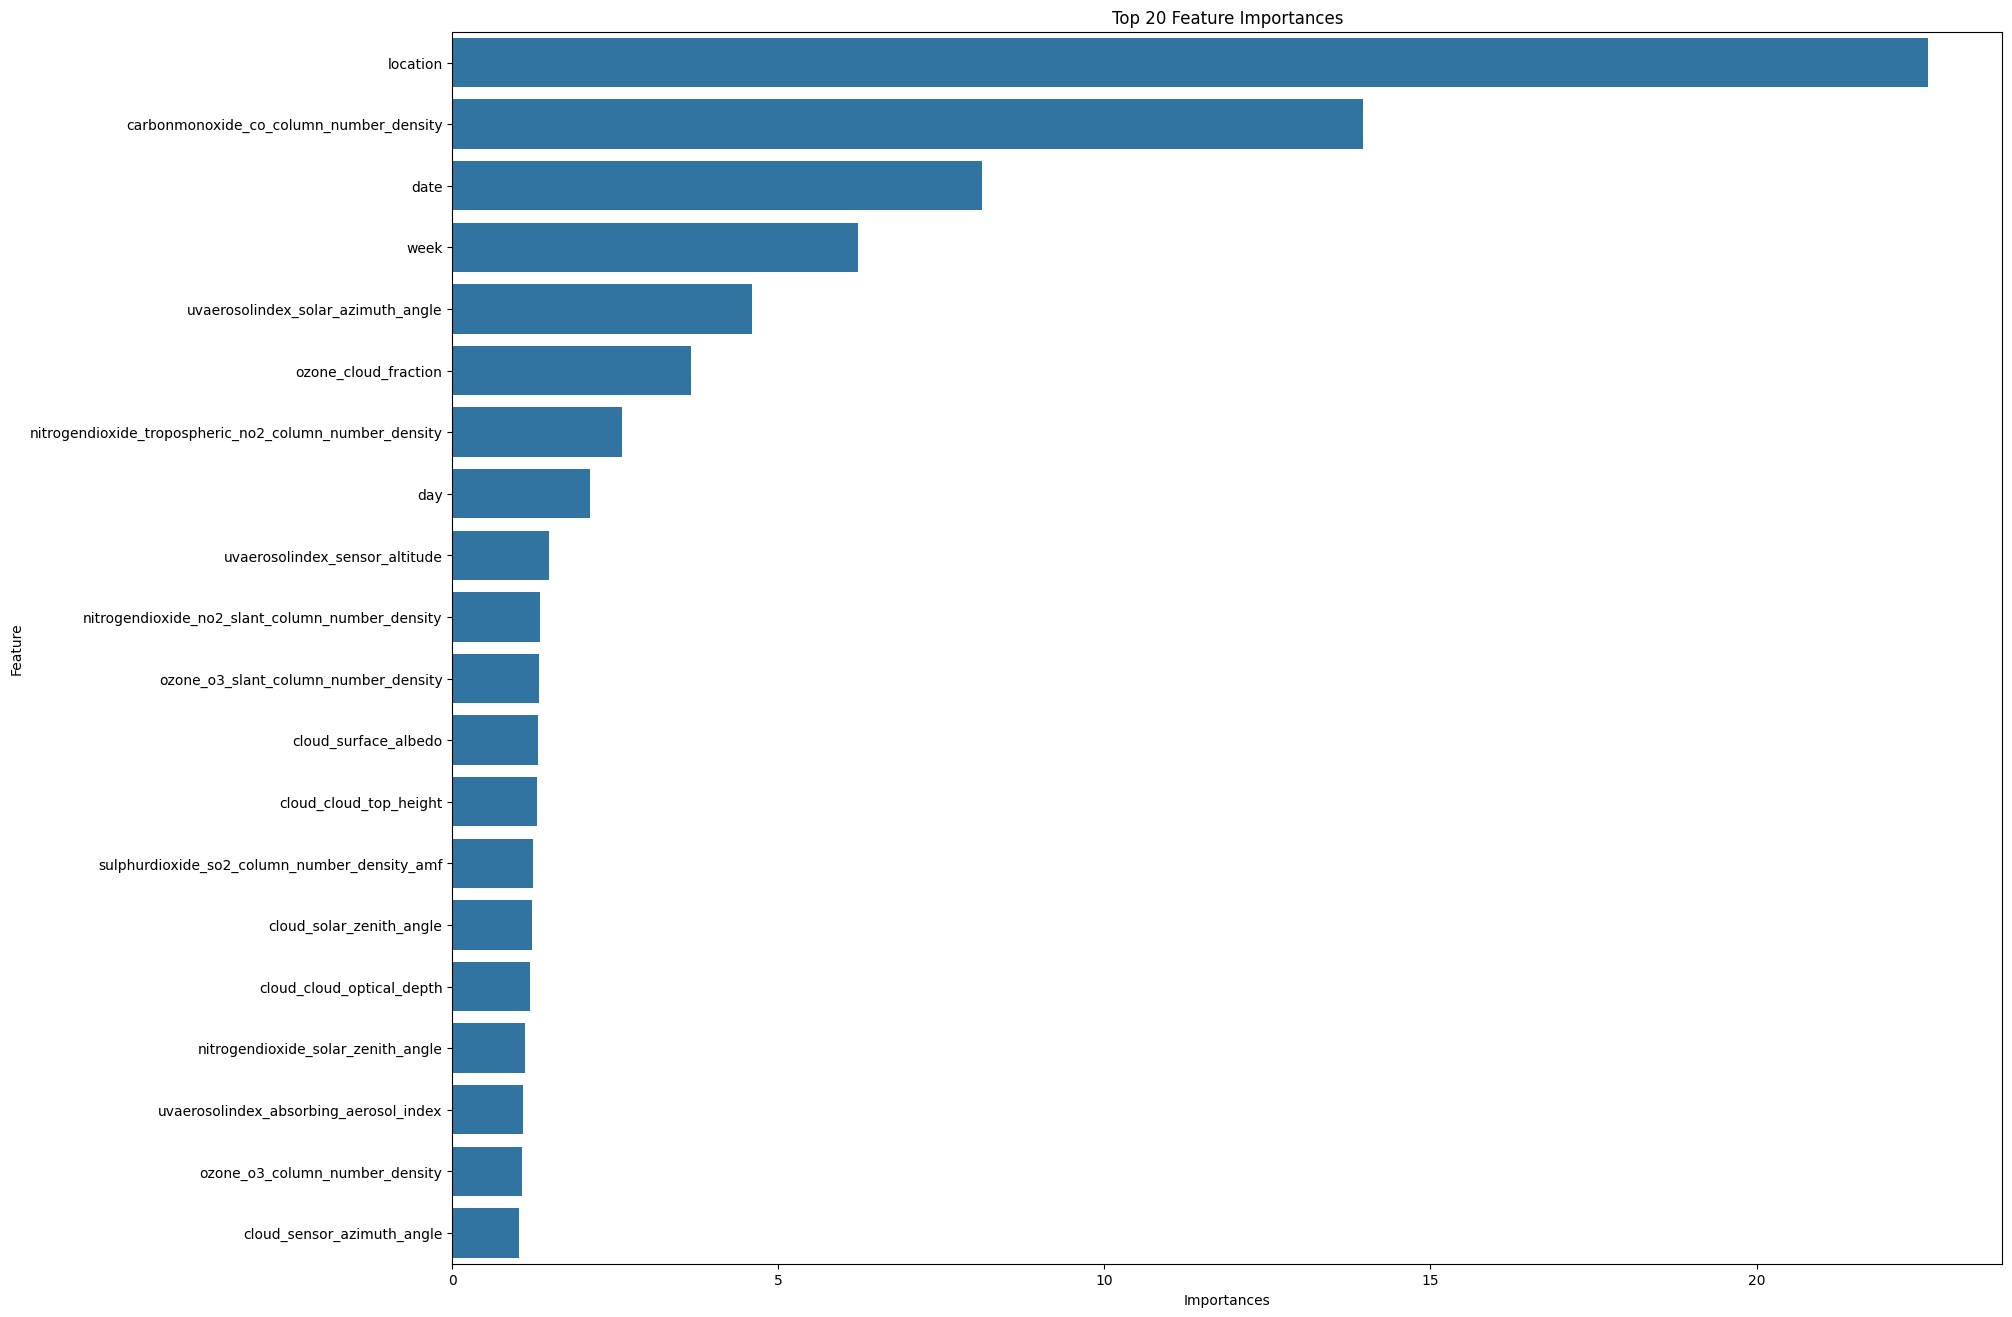

In [284]:
# Plot feature importance from best CatBoost model
plt.figure(figsize=(20, 16))
feature_importances_df = pd.DataFrame(best_models['cat'].feature_importances_, columns=['Importances'])
feature_importances_df['Feature'] = reduced_features
sns.barplot(x='Importances', y='Feature', data=feature_importances_df.sort_values(by=['Importances'], ascending=False).head(20))
plt.title('Top 20 Feature Importances')
plt.show()

## Prepare test submission

In [285]:
def prepare_submission(test, best_test_pred):
    test['pm2_5'] = best_test_pred
    submission = test[[Config.id_col, 'pm2_5']]
    submission.to_csv('submission.csv', index=False)
    submission.head()

prepare_submission(test, best_test_pred)

### Load best models and save submission

In [ ]:
# Load best models
rmse = 27.84 # replace with your choice
folder_name = f"./weights/{rmse:.2f}"
models = {}
for model_name in ['cat', 'lgb', 'xgb', 'lasso', 'svr']:
    models[model_name] = joblib.load(f"{folder_name}/best_model_{model_name}.pkl")  

# Prepare test predictions
test_preds = np.zeros((len(test), len(models)))

# Predict
for i, (name, model) in enumerate(models.items()):
    test_preds[:, i] = model.predict(test[reduced_features])

# Ensemble with equal weights
final_test_pred = np.mean(test_preds, axis=1)

# Save final submission
# prepare_submission(test, final_test_pred)